# OpenVLA evaluation on LIBERO benchmark

Section 1: Initialize OpenVLA with Huggingface transformer

In [ ]:
%env TRANSFORMERS_CACHE=/data2/zhaoyu/huggingface_cache
# os.environ['TRANSFORMERS_CACHE'] = '/data2/zhaoyu/huggingface_cache'
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
import torch.nn as nn

## Load Processor & VLA
processor = AutoProcessor.from_pretrained("openvla/openvla-7b", trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(
    "openvla/openvla-7b",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True
).to("cuda:2")
# print(processor)
# print(vla)

Section 2: Use OpenVLA for inference

env: MUJOCO_GL=osmesa
LIBERO evaluation BDDL files path:  /home/zhaoyu/Workspace/VLA-Continual-Learning/external/LIBERO/libero/libero/./bddl_files
LIBERO evaluation initial states path:  /home/zhaoyu/Workspace/VLA-Continual-Learning/external/LIBERO/libero/libero/./init_files
Video saving to:  ../eval_record/videos
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10 tasks for evaluation:
 ['LIVING_ROOM_SCENE2_put_both_the_alphabet_soup_and_the_tomato_sauce_in_the_basket', 'LIVING_ROOM_SCENE2_put_both_the_cream_cheese_box_and_the_butter_in_the_basket', 'KITCHEN_SCENE3_turn_on_the_stove_and_put_the_moka_pot_on_it', 'KITCHEN_SCENE4_put_the_black_bowl_in_the_bottom_drawer_of_the_cabinet_and_close_it', 'LIVING_ROOM_SCENE5_put_the_white_mug_on_the_left_plate_and_put_the_yellow_and_white_mug_on_the_right_plate', 'STUDY_SCENE1_pick_up_the_book_and_place_it_in_the_back_compartment_of_the_caddy', 'LIVING_ROOM_SCENE6_put_the_white_mug_on_the_plate_and_put_the_chocolate_pudding_to_the_right_

/data/zhaoyu/anaconda3/envs/VLA_CL/lib/python3.8/site-packages/numba/np/arraymath.py:3845: DeprecationWarning: `np.MachAr` is deprecated (NumPy 1.22).
  @overload(np.MachAr)


Initial RGB observations:


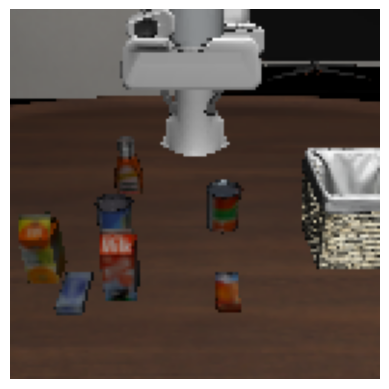

Saved videos to ../eval_record/videos.


In [3]:
%env MUJOCO_GL=osmesa
# os.environ['MUJOCO_GL'] = 'osmesa'
# must be set before importing mujoco_py for headless rendering
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from PIL import Image
# Add VLA_DIR to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '../')))
# Add LIBERO to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '../external/LIBERO')))
from libero.libero.utils.time_utils import Timer
from libero.libero.utils.video_utils import VideoWriter
from libero.libero import benchmark, get_libero_path
from libero.libero.envs import OffScreenRenderEnv, SubprocVectorEnv
# from libero.lifelong.metric import (
#     evaluate_loss,
#     evaluate_success,
#     raw_obs_to_tensor_obs,
# )
# from libero.lifelong.utils import (
#     control_seed,
#     safe_device,
#     torch_load_model,
#     NpEncoder,
#     compute_flops,
# )
from utils.LIBERO_utils import get_task_names, extract_task_info, extract_env_obs

## User specific configurations
# TODO: change this into argparse for user input in python file
DATASET_NAME = "libero_10" # "libero_object", "libero_spatial", "libero_goal", "libero_10", "libero_90"
SAVE_VIDEO = True # save video of the evaluation process
EVAL_MAX_STEP = 500 # maximum number of steps for evaluation
DEVICE_ID = 3 # GPU device id for rendering
PARALLEL_ENVS = 1 # number of parallel environments for evaluation
TEST_ENV = True # test environment with specific actions
if TEST_ENV:
    ACTION_PATH = "../demo_record/actions/KITCHEN_SCENE3_turn_on_the_stove_and_put_the_moka_pot_on_it_demo"

## Check evaluation configureations path
BDDL_FILES_BASE_PATH = get_libero_path("bddl_files")
INIT_STATES_BASE_PATH = get_libero_path("init_states")
VIDEO_FOLDER = "../eval_record/videos"
print("=====================================")
print("LIBERO evaluation BDDL files path: ", BDDL_FILES_BASE_PATH)
print("LIBERO evaluation initial states path: ", INIT_STATES_BASE_PATH)
if SAVE_VIDEO:
    print("Video saving to: ", VIDEO_FOLDER)
print("=====================================")


## Load evaluation environment
benchmark_dict = benchmark.get_benchmark_dict()
benchmark_instance = benchmark_dict[DATASET_NAME]()
tasks_num_eval = benchmark_instance.get_num_tasks() # number of tasks for evaluation
task_names_eval = benchmark_instance.get_task_names() # task names for evaluation
print(f"{tasks_num_eval} tasks for evaluation:\n {task_names_eval}")

# load a task for evaluation
task_id_eval = 0 # TODO: change this into for loop for all tasks
task_eval = benchmark_instance.get_task(task_id_eval)
language_instruction_eval = benchmark_instance.get_task(task_id_eval).language # language instruction for the task
# print(language_instruction_eval)

## Evaluation
with Timer() as t, VideoWriter(VIDEO_FOLDER, SAVE_VIDEO) as video_writer:
    env_args = {
        "bddl_file_name": os.path.join(
            BDDL_FILES_BASE_PATH, task_eval.problem_folder, task_eval.bddl_file
        ),
        "render_gpu_device_id": DEVICE_ID
    }

    env = SubprocVectorEnv(
        [lambda: OffScreenRenderEnv(**env_args) for _ in range(PARALLEL_ENVS)]
    )
        
    env.reset()
    env.seed(0)

    init_states_path = os.path.join(
        INIT_STATES_BASE_PATH, task_eval.problem_folder, task_eval.init_states_file
    )
    init_states = torch.load(init_states_path)
    indices = np.arange(PARALLEL_ENVS) % init_states.shape[0]
    init_states_ = init_states[indices]

    dones = [False] * PARALLEL_ENVS
    steps = 0
    obs = env.set_init_state(init_states_)
    
    for _ in range(10):  # simulate the physics without any actions
            env.step(np.zeros((PARALLEL_ENVS, 7)))
    
    print("Initial RGB observations:")
    stacked_image = np.hstack([obs[k]["agentview_image"][::-1] for k in range(PARALLEL_ENVS)])
    plt.imshow(stacked_image)
    plt.axis('off')
    plt.show()

    ## Testing environment with specific actions
    '''
    taking 6min for 500 steps
    '''
    if TEST_ENV:
        actions = np.load(ACTION_PATH + "/0.npy")
        for timestep in range(actions.shape[0]):
            obs, reward, done, info = env.step([actions[timestep]])
            video_writer.append_vector_obs(obs, done, camera_name="agentview_image")
        env.close()
    
    ## Use OpenVLA for evaluation
    else:
        for _ in range(EVAL_MAX_STEP):
            # collect image
            image = obs[0]["agentview_image"][::-1]
            image = Image.fromarray(image)
            prompt = f"In: What action should the robot take to {language_instruction_eval}?\nOut:"
            # Process the image and prompt
            with torch.no_grad():
                inputs = processor(prompt, image).to(f"cuda:{2}", dtype=torch.bfloat16)
                # generate actions using OpenVLA
                action = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False)
            action = np.array([action])
            # step the environment
            obs, reward, done, info = env.step(action)
            # record video
            video_writer.append_vector_obs(obs, done, camera_name="agentview_image")
            print(f"Step: {_} / {EVAL_MAX_STEP}, Action: {action}")
            
        env.close()
    
    # TODO       
    # ## Use OpenVLA for evaluation with parallel environments
    # for _ in range(EVAL_MAX_STEP):
    #     # collect images from all parallel environments
    #     images_batch = [obs[k]["agentview_image"][::-1] for k in range(PARALLEL_ENVS)]
    #     images_batch = [
    #         Image.fromarray(image) if isinstance(image, np.ndarray) else image
    #         for image in images_batch
    #     ]
    #     images_batch = [image.convert("RGB") for image in images_batch]
    #     # generate prompts based on the language instruction
    #     prompts = [f"In: What action should the robot take to {language_instruction_eval}?\nOut:" for _ in range(PARALLEL_ENVS)]
    #     # Process the images and prompts
    #     inputs = processor(text=prompts, images=images_batch, return_tensors="pt", padding=True).to("cuda:2")
    #     for key, value in inputs.items():
    #         print(f"Shape of {key}: {value.shape}")
    #     # generate actions using OpenVLA
    #     with torch.no_grad():
    #         actions = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False)

    #     # step the environment
    #     obs, reward, done, info = env.step(actions)
        
    #     # record video
    #     video_writer.append_vector_obs(obs, done, camera_name="agentview_image")
